In [1]:
import random

import gain_loss_asymetry as glasym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch
import train_garch

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

In [4]:
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
# plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= 4000].index
stocks = stocks.drop(["SPY"])  # drop the index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-4000]
real_data = real_data.loc[first_date:, stocks]
print(np.sum(np.isnan(real_data), axis=0))
print(f"Shape: {real_data.shape}")
# plt.plot(real_data)
# plt.show()

MMM     0
CVX     0
MO      0
KO      0
AEP     0
       ..
LULU    0
ULTA    0
MSCI    0
PM      0
V       0
Length: 431, dtype: int64
Shape: (4000, 431)


In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_log_price = np.cumsum(np_ret, axis=0)

GenInvGamma fit did NOT converge successfully after 800 iterations.
GenInvGamma fit did NOT converge successfully after 800 iterations.
Real Data gain-loss-asym arg_diff 7.0
Real Data gain-loss-asym arg_diff_std 10.527838328442964
Real Data gain-loss-asym arg_diff_min -6.0
Real Data gain-loss-asym arg_diff_max 56.5
Real Data gain-loss-asym arg_diff_mean 11.932714617169374
Real Data gain-loss-asym arg_max_gain 16.5
Real Data gain-loss-asym arg_max_loss 9.5
Real Data gain-loss-asym arg_max_gain_std 13.795329944504163
Real Data gain-loss-asym arg_max_loss_std 6.970723433808588
Real Data gain-loss-asym gain_likelyhood 0.002930396496095727
Real Data gain-loss-asym loss_likelyhood 0.0029798563950338866


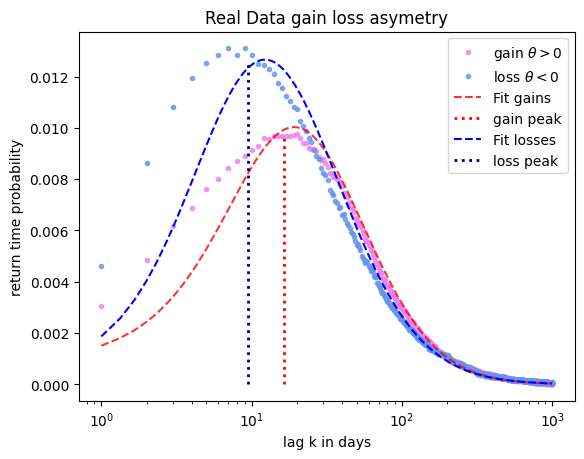

In [7]:
stats = [
    # "max_gain",
    # "max_loss",
    # "max_gain_std",
    # "max_loss_std",
    # "diff",
    # "diff_std",
    "arg_diff",
    "arg_diff_std",
    "arg_diff_min",
    "arg_diff_max",
    "arg_diff_mean",
    "arg_max_gain",
    "arg_max_loss",
    "arg_max_gain_std",
    "arg_max_loss_std",
    "gain_likelyhood",
    "loss_likelyhood",
]
glasym.visualize_stat(plt.gca(), np_log_price, "Real Data", stats)
# plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/le.png")
plt.show()
plt.close()

## Garch Normal, p=3, q=3

In [8]:
cache = "../data/cache/Garch_normal_3_3_2024_06_26-11_11_24"
garch_log_rets = train_garch.sample_garch(cache)

# Drop bad fits
garch_log_rets = garch_log_rets[:, np.sum(np.isnan(garch_log_rets), axis=0) == 0]
garch_log_prices = np.cumsum(garch_log_rets, axis=0)

/home/nico/edu/masterthesis/code/src/garch/train_garch.py:131: RuntimeWarning: invalid value encountered in log
  log_returns.append(np.log(return_simulation))


GenInvGamma fit did NOT converge successfully after 800 iterations.
GenInvGamma fit did NOT converge successfully after 800 iterations.
GARCH normal 3 3 gain-loss-asym arg_diff 1.0
GARCH normal 3 3 gain-loss-asym arg_diff_std 3.9930711491618123
GARCH normal 3 3 gain-loss-asym arg_max_gain 10.5
GARCH normal 3 3 gain-loss-asym arg_max_loss 9.5
GARCH normal 3 3 gain-loss-asym arg_max_gain_std 6.783951929422727
GARCH normal 3 3 gain-loss-asym arg_max_loss_std 5.032045230922428
GARCH normal 3 3 gain-loss-asym gain_likelyhood 0.0036103432238057706
GARCH normal 3 3 gain-loss-asym loss_likelyhood 0.0033196871519111885


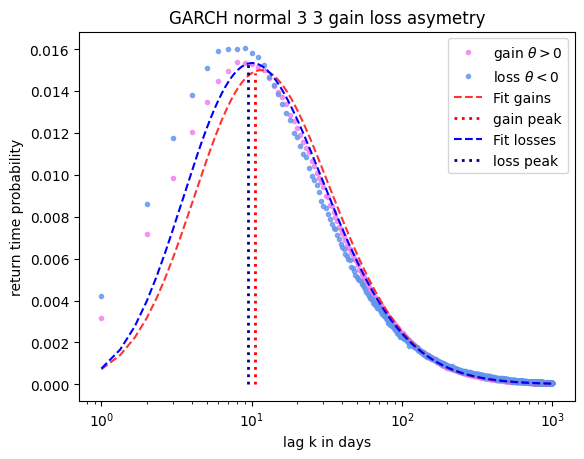

In [9]:
stats = [
    # "max_gain",
    # "max_loss",
    # "max_gain_std",
    # "max_loss_std",
    # "diff",
    # "diff_std",
    "arg_diff",
    "arg_diff_std",
    "arg_max_gain",
    "arg_max_loss",
    "arg_max_gain_std",
    "arg_max_loss_std",
    "gain_likelyhood",
    "loss_likelyhood",
]
glasym.visualize_stat(plt.gca(), garch_log_prices, "GARCH normal 3 3", stats)
# plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/le.png")
plt.show()
plt.close()